## The Problem

We have decomposed the foregrounds and 21-cm signal into a set of spherical 
harmonic coefficients, $a_{lm}(\nu)$. Now we wish to separate them from one
another by choosing a model for the foreground component, a model for the 21-cm
component, and fitting both models to the data using MCMC. We expect the 21-cm 
signal to only be present in the $l=0$ mode. 

A standard approach is to assume that the foreground component is a log-power
law, and the 21-cm signal is a Gaussian. This can be problematic, as the 
log-power law can be very degenerate with the 21-cm signal. 

In this notebook, we try a different approach: using the higher $l$ modes of the 
spherical harmonic decomposition (which contain vanishing contrinbutions from
the 21-cm signal) to inform the functional representation of the foregrounds.

## How we do this

We assume a power law with running specified by the PCA basis B:

$$ C_l = A_l \nu ^{\gamma_l} 10^{\gamma_l B \cdot \theta_{PCA}} $$

We collapse the individual l-modes for $l>0$ by fitting a power law through them, and
run them through PCA to find the basis B. This forms our foreground model for the
$l=0$ mode:

$$ C_0 = A_0 \nu ^{\gamma_0} 10^{\gamma_0 B \cdot \theta_{PCA}} $$

Since the power law running for the zeroth order mode is informed by the higher
order modes, we expect that this model could
1. Fit the foregrounds better for the same number of parameters as the log-polynomial
model.
2. Be less degenerate with the 21-cm signal Gaussian, as the PCA has not "seen"
anything like a Gaussian in the training step.

In [1]:
import healpy as hp
import emcee
from chainconsumer import ChainConsumer
import matplotlib.pyplot as plt
import numpy as np

import src.powerlaw_regression as PR
import src.sky_models as SM
from src.spherical_harmonics import RealSphericalHarmonics
RS = RealSphericalHarmonics()

In [2]:
def splitvec(vec, nsplit):
    """
    Split a vector of length m into nsplit pieces, returning an array of shape
    nsplit x (m/nsplit).
    """
    if len(vec)%nsplit:
        raise ValueError("nsplit must divide vector length.")
    newvec = np.reshape(a=vec, newshape=(nsplit, int(len(vec)/nsplit)))
    return newvec

def gen_cl_matrix(nside=32, lmax=64, nuarr=np.linspace(50,100,51), sqrt=True):
    """
    Generate the power spectrum matrix (Nlmax, Nfreq) for the GSMA. If sqrt is 
    true, computes the square root of the matrix.
    """
    # Check the foreground generation is working.
    a, mp = SM.foreground_gsma_alm(nu=nuarr, map=True, lmax=lmax, nside=nside)
    a_sep = splitvec(a, len(nuarr))

    a_sep_compl = [RS.real2ComplexALM(almr) for almr in a_sep]
    cls = [hp.sphtfunc.alm2cl(almc) for almc in a_sep_compl]
    return np.sqrt(np.array(cls).T)

def preprocess_cl_matrix(cl_mat):
    """
    Multiply the power spectrum elements by l(l+1) for each row (ell) of the
    power spectrum matrix.
    """
    lmax = np.shape(cl_mat)[0]
    norm = np.array([l*(l+1) for l in range(lmax)])
    normed_cl_mat = cl_mat.T * norm
    return normed_cl_mat.T


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


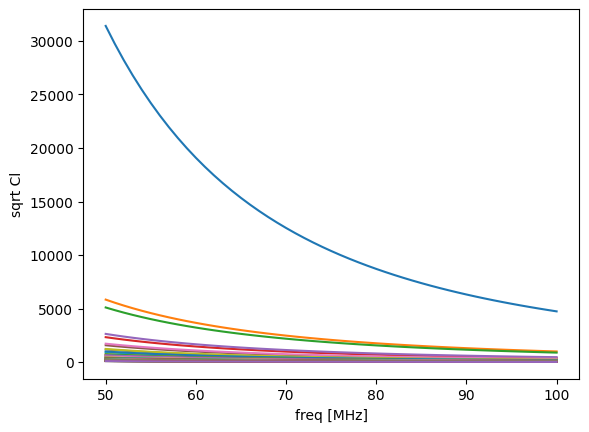

In [3]:
# Generate the power spectrum matrix.
nuarr = np.linspace(50,100,51)
cl_mat = gen_cl_matrix(nuarr=nuarr)

plt.plot(nuarr, cl_mat.T)
plt.xlabel("freq [MHz]")
plt.ylabel("sqrt Cl")
plt.show()

[[ 8.20666873 -2.55694612]
 [ 8.07834082 -2.52727862]
 [ 7.28306456 -2.56968081]]


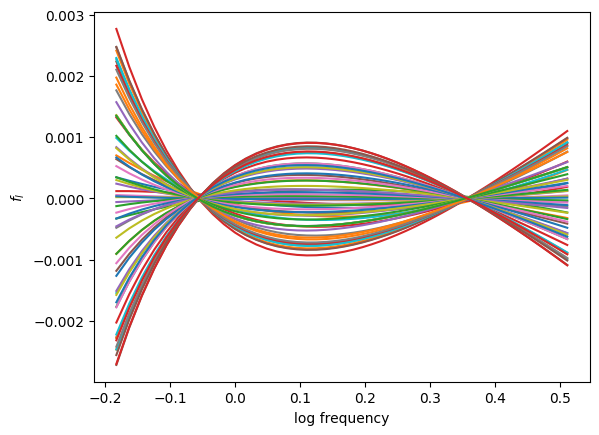

In [4]:
# Collapse the l>1 modes of the Cl matrix.
_, _, fitpars_c0 = PR.power_law_residuals(nuarr/60, cl_mat[0])
lognu, resid, fitpars = PR.power_law_residuals(nuarr/60, cl_mat[1:])
print(fitpars[:3])
plt.plot(lognu, resid.T)
plt.xlabel("log frequency")
plt.ylabel('$f_l$')
plt.show()

In [5]:
# SVD the residual matrices to find a basis.
Npca = 4
coord_mat, basis_mat = PR.pca(resid, N=Npca)

In [6]:
def log_likelihood(theta, nuarr, y, yerr):
    y_model = PR.fg_powerlawPCA_forward_model(nuarr, theta, basis_mat.T)
    chi2 = (y - y_model)**2 / (yerr**2)
    return np.sum(-chi2 / 2)

def log_prior(theta):
    lower =  theta > prior_range[:,0]
    upper = theta < prior_range[:,1]
    in_prior_range = all(lower & upper)

    #return prior value
    if in_prior_range:
        return 0.0
    return -np.inf

def log_posterior(theta, x, y, yerr):
    """
    Return the Gaussian log-posterior, with flat priors and a Gaussian
    likelihood, given a parameter vector theta, and data y with error yerr.

    Returns -inf if theta passed is outside the prior range.
    """
    lp = log_prior(theta)
    if np.isfinite(lp):
        lp += log_likelihood(theta, x, y, yerr)
    return lp


prior_range=[(np.exp(9), np.exp(10)),(-5, -2),(-1e-3, 1e-3+1e-4),(-1e-3, 1e-3+1e-4),(-1e-3, 1e-3+1e-4),(-1e-3, 1e-3+1e-4)]
prior_range = np.array(prior_range)

# create a small ball around the MLE the initialize each walker
nwalkers, ndim = 30, len(prior_range)
theta_guess = np.array([0.5*(bound[0]+bound[1]) for bound in prior_range])
pos = theta_guess*(1 + 1e-4*np.random.randn(nwalkers, ndim))

# run emcee
Nstep = 10000
yerr = np.ones(np.shape(cl_mat[0]))
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(nuarr, cl_mat[0], yerr))
sampler.run_mcmc(pos, Nstep, progress=True)

100%|██████████| 10000/10000 [00:16<00:00, 597.31it/s]


State([[ 1.90862299e+04 -2.72823932e+00  6.39016300e-04  2.25975219e-04
  -8.24006900e-06 -1.49851607e-06]
 [ 1.90861470e+04 -2.72822249e+00  6.45066493e-04  2.23036823e-04
   3.41949072e-05 -4.63652676e-05]
 [ 1.90862344e+04 -2.72843974e+00  5.73306716e-04  1.36496070e-04
   3.08010405e-06 -2.71150699e-05]
 [ 1.90865114e+04 -2.72831798e+00  5.87635939e-04  1.89914863e-04
  -3.33463996e-06 -3.15680346e-05]
 [ 1.90860278e+04 -2.72818967e+00  6.54068737e-04  2.28033315e-04
  -3.26954338e-05  1.27501497e-05]
 [ 1.90864031e+04 -2.72828657e+00  5.95901394e-04  1.71488447e-04
  -4.92263743e-06  9.49668702e-06]
 [ 1.90866669e+04 -2.72838793e+00  5.59310984e-04  1.04237801e-04
   4.13619625e-05 -8.52463841e-07]
 [ 1.90864294e+04 -2.72841191e+00  5.58563503e-04  1.75222478e-04
   2.52926978e-05  8.16456496e-06]
 [ 1.90863085e+04 -2.72841680e+00  5.07674580e-04  5.17404861e-05
   1.00720626e-04 -8.12246692e-05]
 [ 1.90863828e+04 -2.72823168e+00  6.06862368e-04  2.00160592e-04
   1.06974859e-05 -

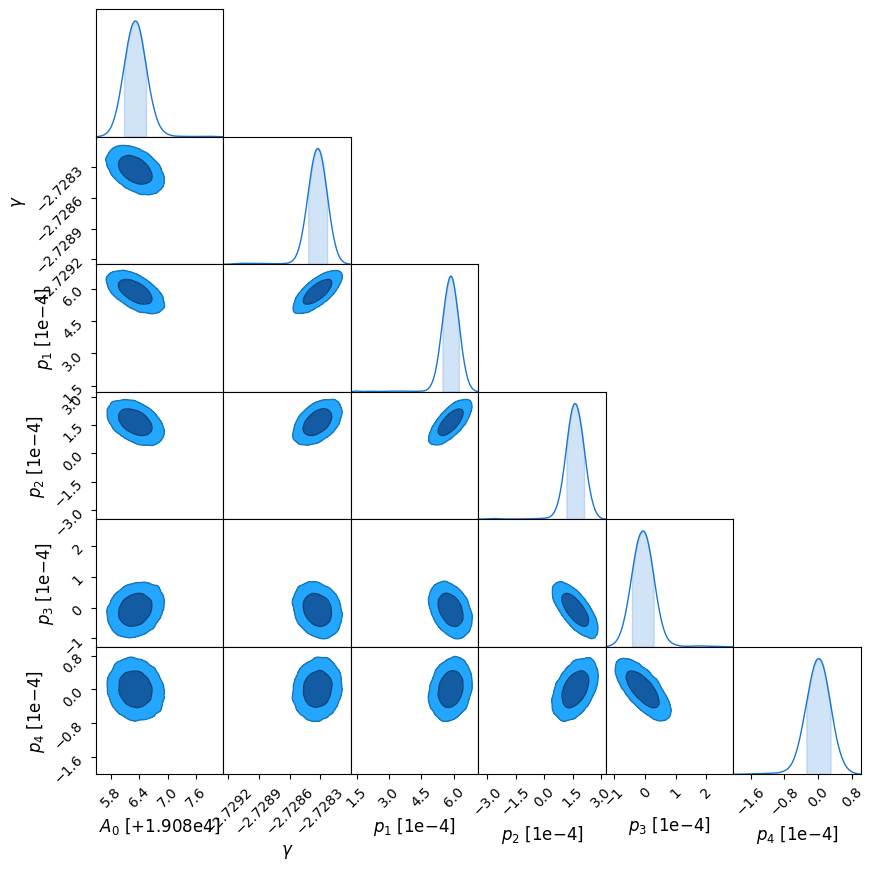

In [7]:
c=ChainConsumer()
c.add_chain(sampler.get_chain(flat=True)[10000:], parameters=["$A_0$", "$\gamma$", "$p_1$", "$p_2$", "$p_3$", "$p_4$"])
c.plotter.plot()
plt.show()

Now see how good the reconstruction is.

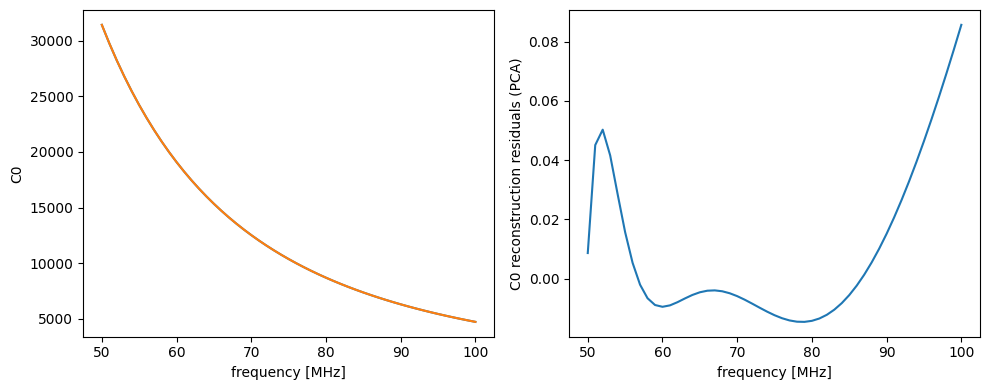

In [8]:
theta_mean = np.mean(sampler.get_chain(flat=True)[10000:], axis=0)
cl0_reconstructed = PR.fg_powerlawPCA_forward_model(nuarr, theta_mean, basis_mat.T)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(nuarr, cl_mat[0])
ax[0].plot(nuarr, cl0_reconstructed)
ax[1].plot(nuarr, cl_mat[0]-cl0_reconstructed)
ax[0].set_xlabel("frequency [MHz]")
ax[0].set_ylabel("C0")
ax[1].set_xlabel("frequency [MHz]")
ax[1].set_ylabel("C0 reconstruction residuals (PCA)")
fig.tight_layout()
plt.show()

Now let's compare it to the performance of the log-polynomial model.

In [9]:
def log_likelihood(theta, nuarr, y, yerr):
    y_model = PR.fg_powerlaw_forward_model(nuarr, theta)
    chi2 = (y - y_model)**2 / (yerr**2)
    return np.sum(-chi2 / 2)

def log_prior(theta):
    lower =  theta > prior_range[:,0]
    upper = theta < prior_range[:,1]
    in_prior_range = all(lower & upper)

    #return prior value
    if in_prior_range:
        return 0.0
    return -np.inf

def log_posterior(theta, x, y, yerr):
    """
    Return the Gaussian log-posterior, with flat priors and a Gaussian
    likelihood, given a parameter vector theta, and data y with error yerr.

    Returns -inf if theta passed is outside the prior range.
    """
    lp = log_prior(theta)
    if np.isfinite(lp):
        lp += log_likelihood(theta, x, y, yerr)
    return lp


prior_range=[(np.exp(9), np.exp(10)),(-5, -2),(-1, 1+1e-4),(-1, 1+1e-4),(-100+1e-2, 100),(-100+1e-2, 100)]
prior_range = np.array(prior_range)

# create a small ball around the MLE the initialize each walker
nwalkers, ndim = 30, len(prior_range)
theta_guess = np.array([0.5*(bound[0]+bound[1]) for bound in prior_range])
pos = theta_guess*(1 + 1e-4*np.random.randn(nwalkers, ndim))

# run emcee
Nstep = 10000
yerr = np.ones(np.shape(cl_mat[0]))
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(nuarr, cl_mat[0], yerr))
sampler.run_mcmc(pos, Nstep, progress=True)

100%|██████████| 10000/10000 [00:26<00:00, 382.69it/s]


State([[ 1.90850073e+04 -2.73090179e+00  8.22310928e-03  6.95699774e-03
  -4.61089021e-02  5.13571724e-02]
 [ 1.90854604e+04 -2.73086956e+00  4.83249546e-03  7.83404859e-03
   1.13519997e-02 -3.92861197e-02]
 [ 1.90853599e+04 -2.73045769e+00  6.87340452e-03  9.70106677e-04
  -2.90055351e-02  5.14060955e-02]
 [ 1.90847108e+04 -2.73058773e+00  8.05517533e-03 -1.70585704e-03
  -1.26691319e-02  1.68792891e-02]
 [ 1.90849758e+04 -2.73074413e+00  5.90730043e-03  3.70192390e-03
   6.35582676e-03 -2.60038253e-02]
 [ 1.90849861e+04 -2.73064796e+00  7.18344884e-03 -4.31891595e-04
  -8.61921001e-03  1.22162702e-02]
 [ 1.90851423e+04 -2.73064161e+00  6.19722032e-03 -6.65043463e-04
   1.35767026e-02 -1.94771856e-02]
 [ 1.90851352e+04 -2.73033192e+00  5.23432813e-03 -6.03701995e-03
   3.89772049e-02 -4.38070301e-02]
 [ 1.90849201e+04 -2.73047098e+00  5.91002298e-03 -5.36880825e-03
   2.58156237e-02 -2.49005856e-02]
 [ 1.90851463e+04 -2.73059888e+00  6.27407420e-03 -2.88725913e-03
   2.14179859e-02 -

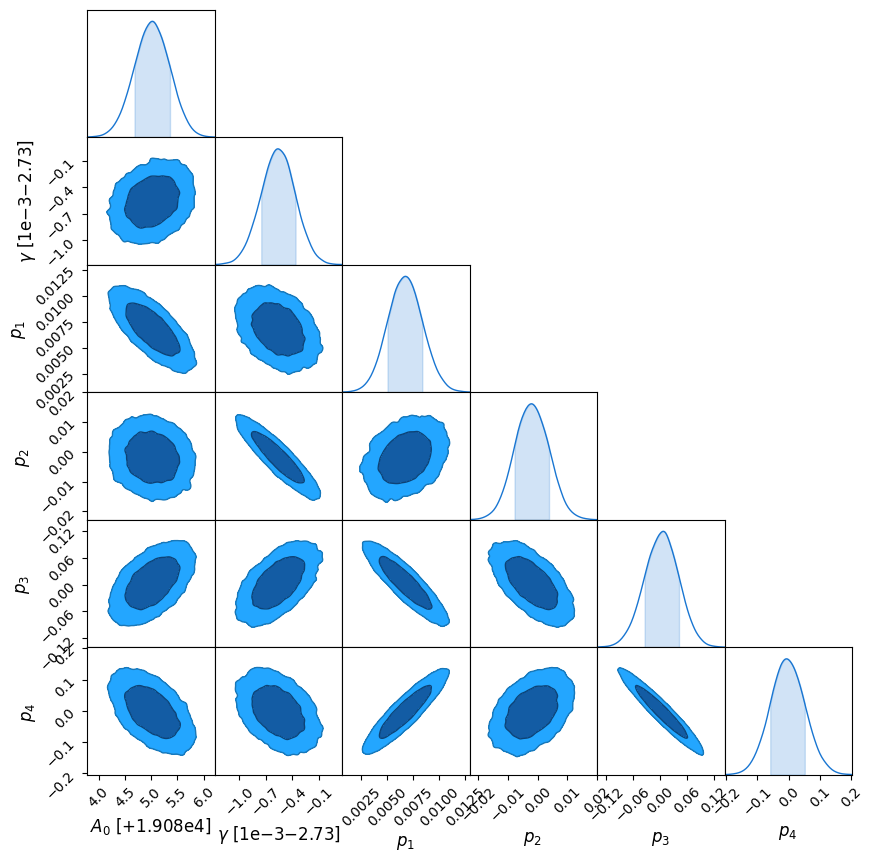

In [10]:
c=ChainConsumer()
c.add_chain(sampler.get_chain(flat=True)[100000:], parameters=["$A_0$", "$\gamma$", "$p_1$", "$p_2$", "$p_3$", "$p_4$"])
c.plotter.plot()
plt.show()

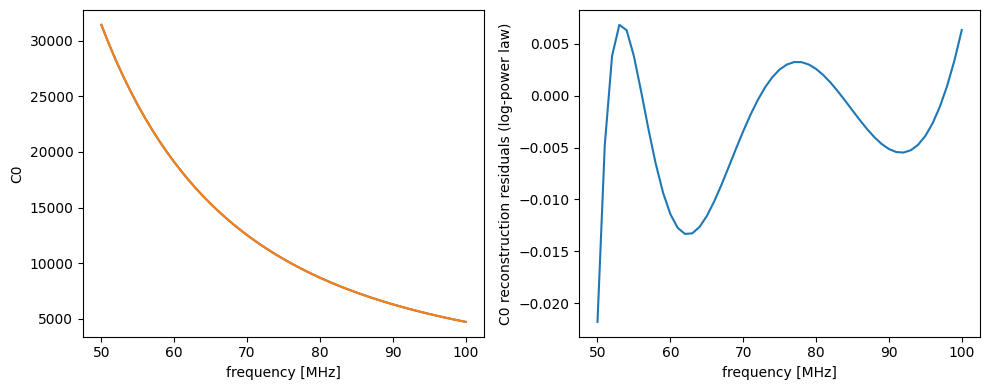

In [11]:
theta_mean = np.mean(sampler.get_chain(flat=True)[10000:], axis=0)
cl0_reconstructed = PR.fg_powerlaw_forward_model(nuarr, theta_mean)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(nuarr, cl_mat[0])
ax[0].plot(nuarr, cl0_reconstructed)
ax[1].plot(nuarr, cl_mat[0]-cl0_reconstructed)
ax[0].set_xlabel("frequency [MHz]")
ax[0].set_ylabel("C0")
ax[1].set_xlabel("frequency [MHz]")
ax[1].set_ylabel("C0 reconstruction residuals (log-power law)")
fig.tight_layout()
plt.show()

## The Results

It looks like the PCA model indeed has the capability to fit the foreground
function better than the standard log-polynomial approach. More testing must be
done to see if
1. This is consistent across other numbers of parameters
2. The PCA model is indeed less degenerate with a Gaussian model than the log-polynomial.

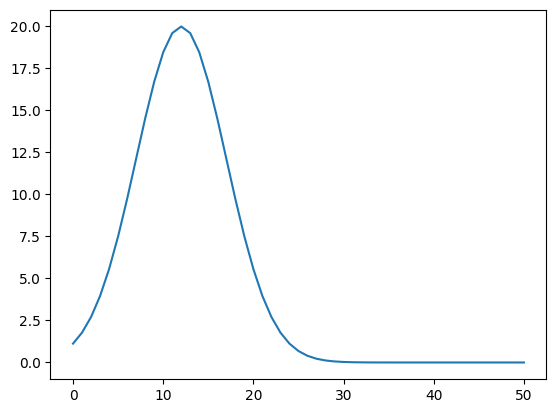

In [13]:

plt.plot(SM.cm21_globalT(nu=nuarr, A=20, nu0=62, dnu=5))

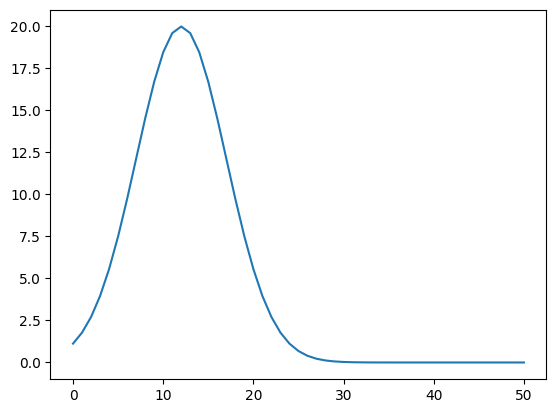

In [21]:
import src.powerlaw_regression as PR

plt.plot(PR.fg_powerlaw_cm21mon_forward_model(nuarr, theta=[0, 0, 20, 62, 5]))